# Performing Calculations

<div>
    <img style='width: 220px;height: 100px;float: left;' src="./Supplementary_data/EODC-Logo-Final.png" height='100px' width='220px'/>
    <img style='width: 200px;height: 100px;float: left;' src="./Supplementary_data/BMNT_DE_Logo_dreizeilig_srgb.svg" height='100px' width='200px'/> 
    <img style='width: 200px;height: 100px;float: left;' src="./Supplementary_data/bmlv.svg" height='100px' width='200px'/>
    <img style='width: 200px;height: 100px;float: left;' src="./Supplementary_data/LOGO_TUW_GEO.png" height='100px' width='200px'/>
    <img style='width: 100px;height: 100px;float: left;' src="./Supplementary_data/Boku-wien.svg" height='100px' width='100px'/>
    <img style='width: 150px;height: 100px;float: right;' src="./Supplementary_data/ADC_Logo_final_transparent.png" height='100px' width='150px'/>
</div>

This notebook shows how to calculate NDVI and NDWI using the appropriate ACube product. It is required to query for the appropriate measurements and perform some calculations in order to calculate the values. Afterwards the values are classified according to the table below.

| Layer         | Band Combination |   Range  | Layer Classification                                     |
| ------------- |:----------------:| --------:| --------------------------------------------------------:|
| NDVI          | B04, B08         | -1 to 1  | (< 0 Waterbody); 0.2 to 0.4 Grassland/field; >0.5 Forest)| 
| NDWI          | B08, B11         | -1 to 1  | >0.5 Waterbody; <0.5 Land                                |

## Initial setup and metadata/measurements of product

From the output below we can see that the product `B_Sentinel_2` has the required bands (B04, B08, B11).

In [1]:
import matplotlib
import datacube
import pprint
%matplotlib inline
matplotlib.rc('font', size=15)
acube = datacube.Datacube(app='sample_5')
products = acube.list_products()
filter = products["platform"]=="Sentinel-2"
products = products.dropna(axis=1).where(filter).dropna()
products.loc[products.name == 'B_Sentinel_2']

name                                 description    platform  \
id                                                                         
1   B_Sentinel_2  Atmospherically corrected Sentinel 2 bands  Sentinel-2   

   product_type instrument   format  \
id                                    
1     BOKU_B_S2        MSI  GeoTIFF   

                                                  crs resolution  \
id                                                                 
1   PROJCS["Azimuthal_Equidistant",GEOGCS["GCS_WGS...  [-10, 10]   

   spatial_dimensions  
id                     
1              (y, x)

In [2]:
measlist=acube.list_measurements()
measlist.loc[measlist.index.get_level_values(0) == 'B_Sentinel_2']

aliases   dtype name  \
product      measurement                                                     
B_Sentinel_2 B02             [band_2, band_02, Band2, Band_2]  uint16  B02   
             B03             [band_3, band_03, Band3, Band_3]  uint16  B03   
             B04             [band_4, band_04, Band4, Band_4]  uint16  B04   
             B05             [band_5, band_05, Band5, Band_5]  uint16  B05   
             B06             [band_6, band_06, Band6, Band_6]  uint16  B06   
             B07             [band_7, band_07, Band7, Band_7]  uint16  B07   
             B08             [band_8, band_08, Band8, Band_8]  uint16  B08   
             B8A          [band_8a, band_8A, Band8A, Band_8A]  uint16  B8A   
             B11                   [band_11, Band11, Band_11]  uint16  B11   
             B12                   [band_12, Band12, Band_12]  uint16  B12   

                          nodata     units  
product      measurement                    
B_Sentinel_2 B02               0  fraction  
             B03               0  fraction  
             B04               0  fraction  
             B05               0  fraction  
             B06               0  fraction  
             B07               0  fraction  
             B08               0  fraction  
             B8A               0  fraction  
             B11               0  fraction  
             B12               0  fraction

## Querying the data

Below we specify the query parameters. In this case we are also requesting that the cloud cover percentage is less than 5%

In [3]:
query = {
    'product': 'B_Sentinel_2',
    'output_crs': 'EPSG:32633',
    'resolution': (-10, 10),
    'lon': (16.24, 16.4),
    'lat': (47.85, 48.0),
    'time': ('2018-01-01', '2018-04-30'),
    'measurements': ['B04', 'B08', 'B11'], 
    'cloud_cover_percentage': (0.0, 5.0)
}
data = acube.load(**query)
data

<xarray.Dataset>
Dimensions:  (time: 21, x: 1225, y: 1688)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-03 2018-01-09 ... 2018-04-29
  * y        (y) float64 5.317e+06 5.317e+06 5.317e+06 ... 5.3e+06 5.3e+06
  * x        (x) float64 5.925e+05 5.925e+05 5.925e+05 ... 6.047e+05 6.047e+05
Data variables:
    B04      (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    B08      (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    B11      (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Attributes:
    crs:      EPSG:32633

## Calculation

Formulas for NDVI and NDWI are below. They are applied on the quried data.

$ndvi = (\frac{B08 - B04}{B08 + B04})$

$ndwi = (\frac{B08 - B11}{B08 + B11})$  

In [4]:
data_new = data.where(data.B04 != 0).dropna(dim='time')

ndvi = ((data_new.B08-data_new.B04)/(data_new.B08+data_new.B04))

ndwi = ((data_new.B08-data_new.B11)/(data_new.B08+data_new.B11))

In [5]:
ndvi

<xarray.DataArray (time: 3, y: 1688, x: 1225)>
array([[[0.653203, 0.571579, ..., 0.730673, 0.380599],
        [0.504838, 0.355765, ..., 0.789682, 0.483252],
        ...,
        [0.445255, 0.460246, ..., 0.746835, 0.764198],
        [0.434472, 0.438134, ..., 0.801054, 0.810676]],

       [[0.737113, 0.680977, ..., 0.685623, 0.351367],
        [0.64352 , 0.628099, ..., 0.796412, 0.43683 ],
        ...,
        [0.428956, 0.444355, ..., 0.766389, 0.777462],
        [0.408719, 0.421719, ..., 0.796839, 0.816   ]],

       [[0.701049, 0.493709, ..., 0.679828, 0.340649],
        [0.509924, 0.249186, ..., 0.742491, 0.392783],
        ...,
        [0.405046, 0.415479, ..., 0.835236, 0.799155],
        [0.397909, 0.41232 , ..., 0.86984 , 0.800977]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-04-18 2018-04-21 2018-04-28
  * y        (y) float64 5.317e+06 5.317e+06 5.317e+06 ... 5.3e+06 5.3e+06
  * x        (x) float64 5.925e+05 5.925e+05 5.925e+05 ... 6.047e+05 6.047e+05

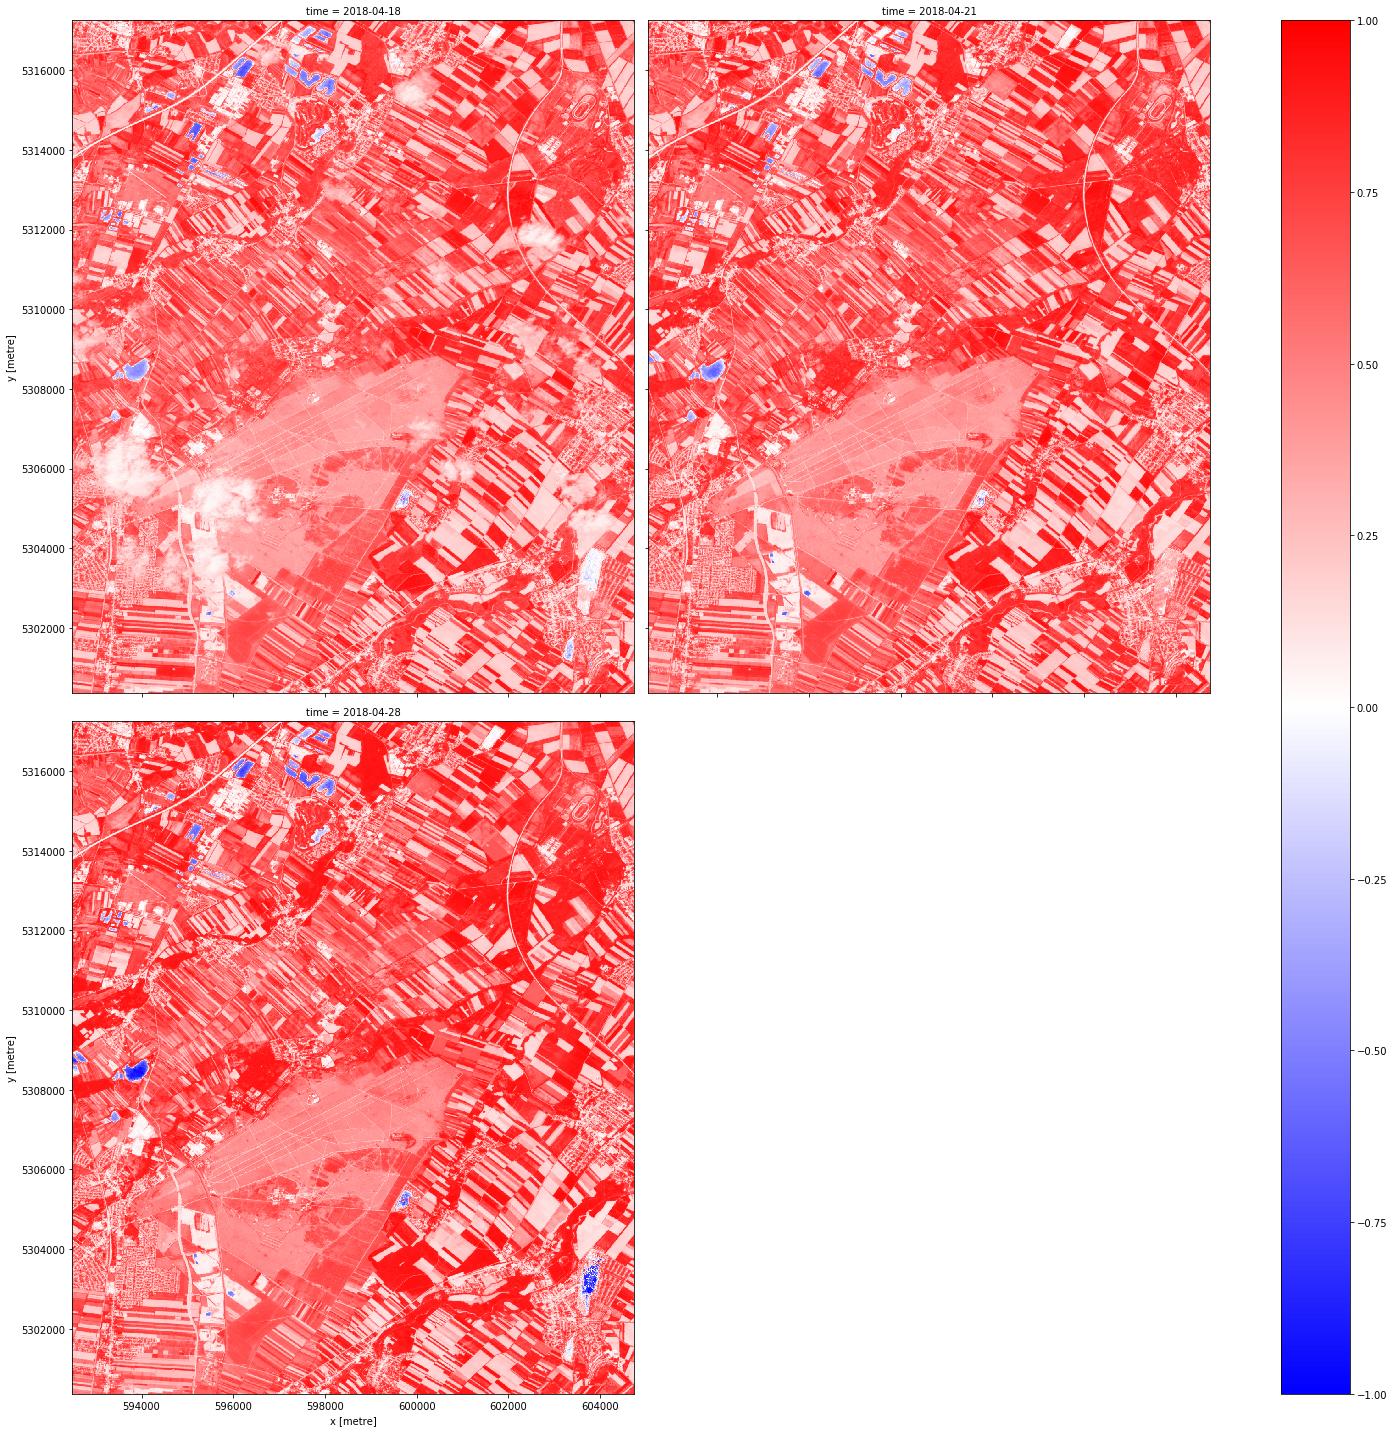

In [6]:
ndvi.plot.imshow(x=data.crs.dimensions[1], 
                 y=data.crs.dimensions[0],
                 col='time',
                 size=10,
                 col_wrap=2,
                 cmap='bwr',
                 vmin=-1, 
                 vmax=1)

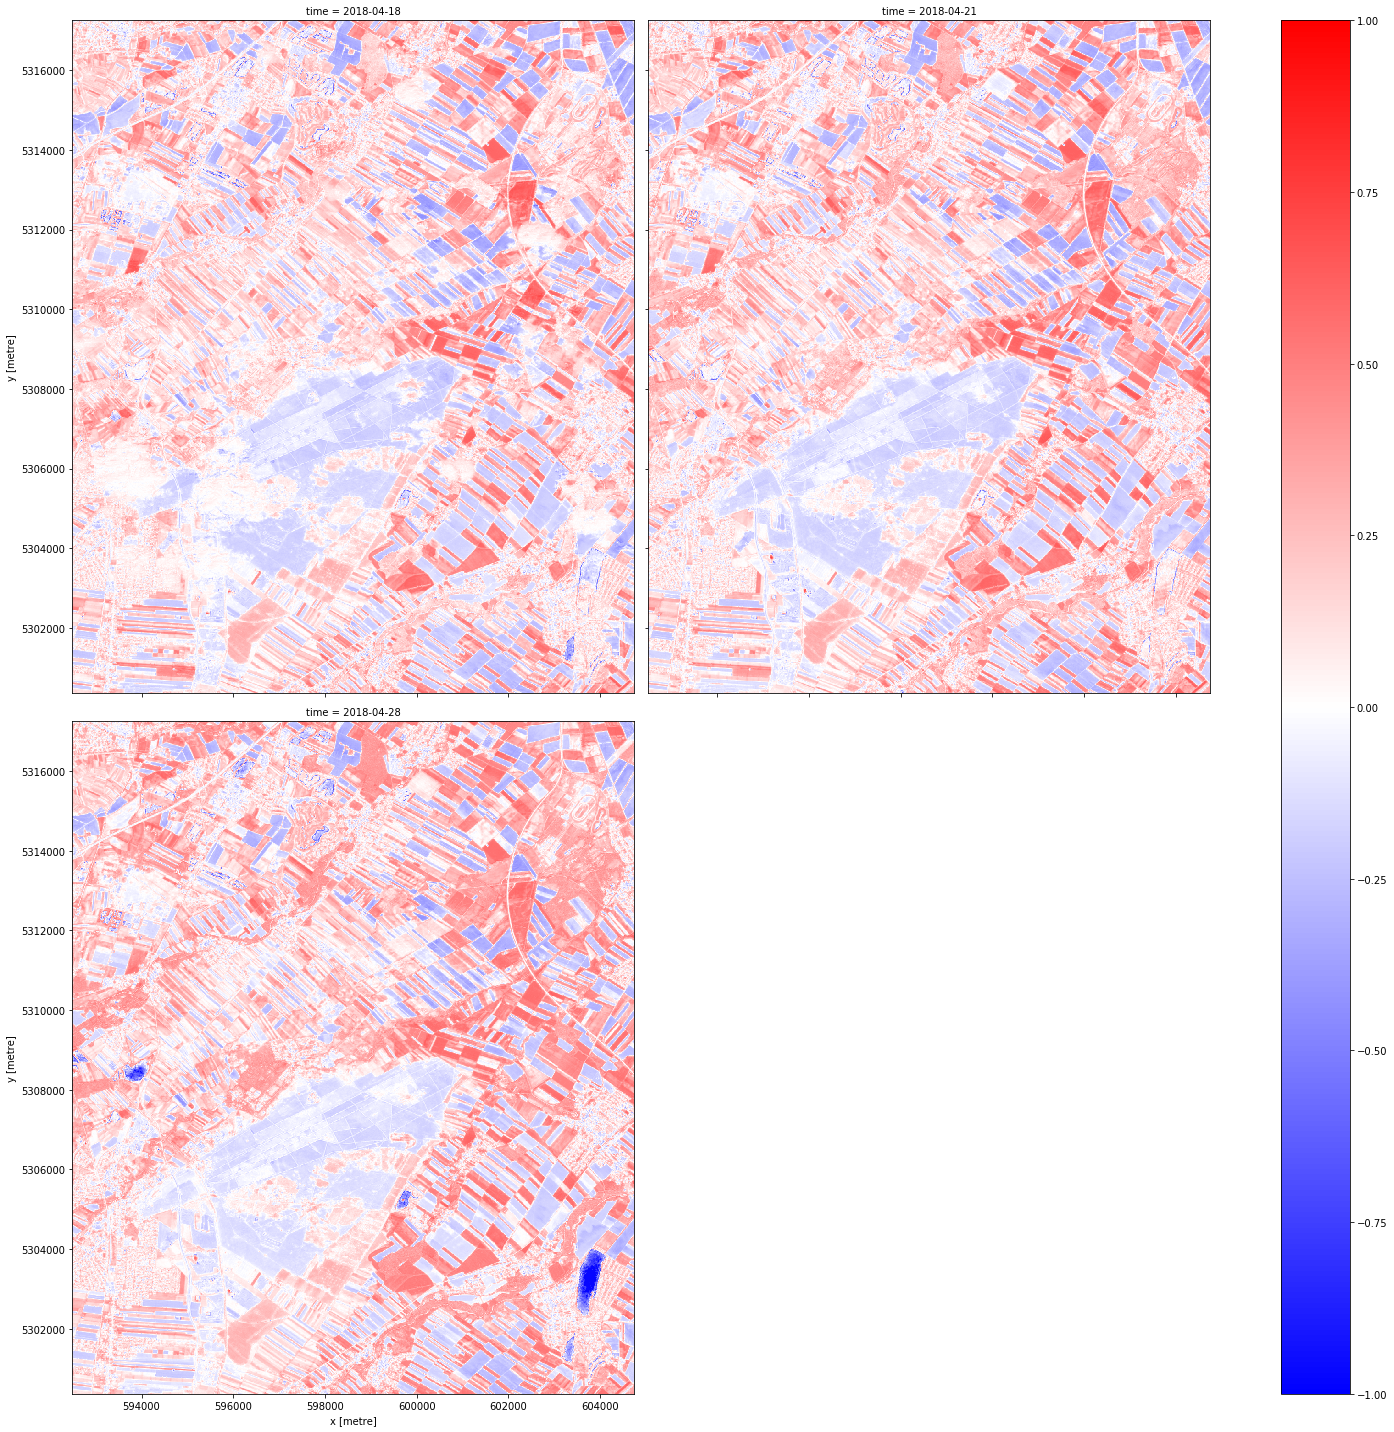

In [7]:
ndwi.plot.imshow(x=data.crs.dimensions[1], 
                 y=data.crs.dimensions[0],
                 col='time',
                 size=10,
                 col_wrap=2,
                 cmap='bwr',
                 vmin=-1, 
                 vmax=1)

## Classification of the data

### NDVI Classification

* 1 - Waterbody x <=0
* 2 - Soil - 0 < x <= 0.2
* 3 - Grassland/field - 0.2 < x <= 0.5
* 4 - Forest - x > 0.5

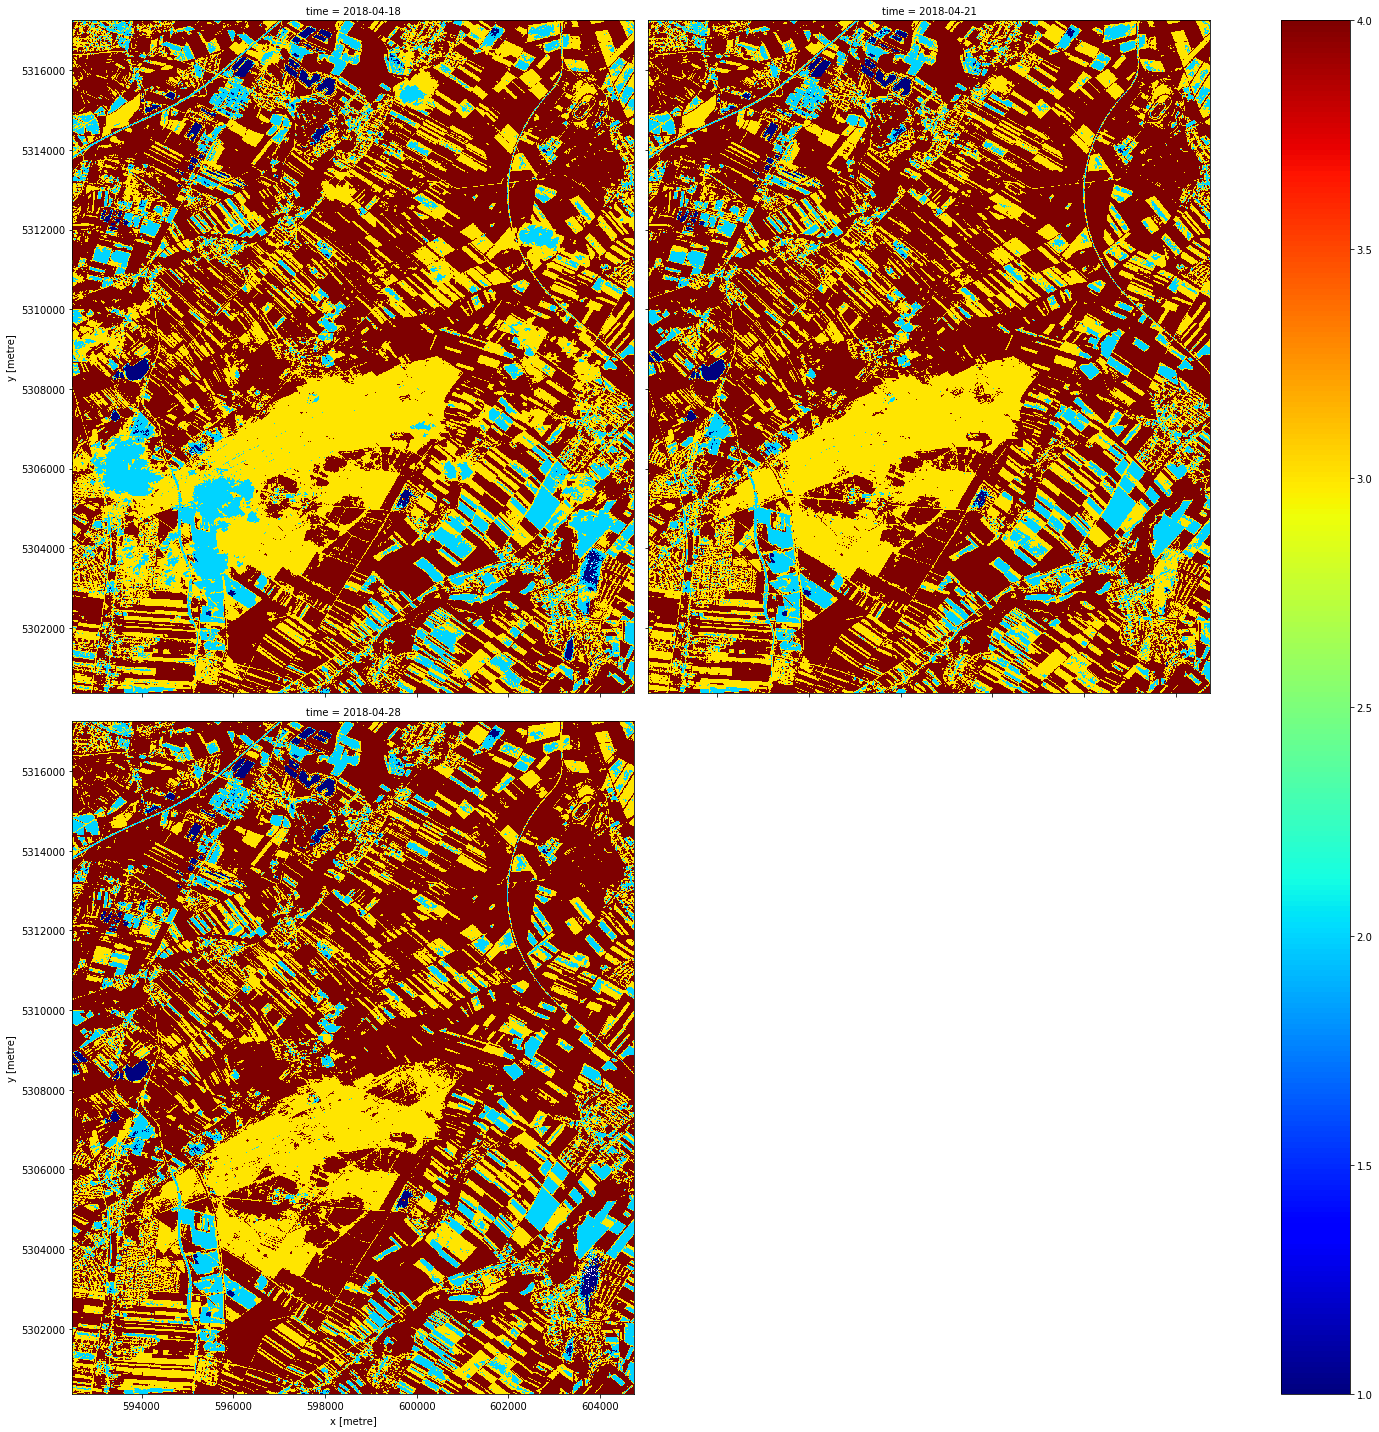

In [8]:
mask_waterbody = 1 * ndvi.where(ndvi <= 0, other=0)/ndvi
mask_soil = 2 * ndvi.where((0 < ndvi) & (ndvi <= 0.2), other=0)/ndvi
mask_grassland = 3 * ndvi.where((0.2 < ndvi) & (ndvi <= 0.5), other=0)/ndvi
mask_forest = 4 * ndvi.where(ndvi > 0.5, other=0)/ndvi
ndvi_classified = mask_forest + mask_grassland + mask_soil + mask_waterbody
ndvi_classified.plot.imshow(x=data.crs.dimensions[1], 
                 y=data.crs.dimensions[0],
                 col='time',
                 size=10,
                 col_wrap=2,
                 cmap='jet')

## NDWI Classification

* 1 - Waterbody > 0.5 
* 2 - Land x<=0.5

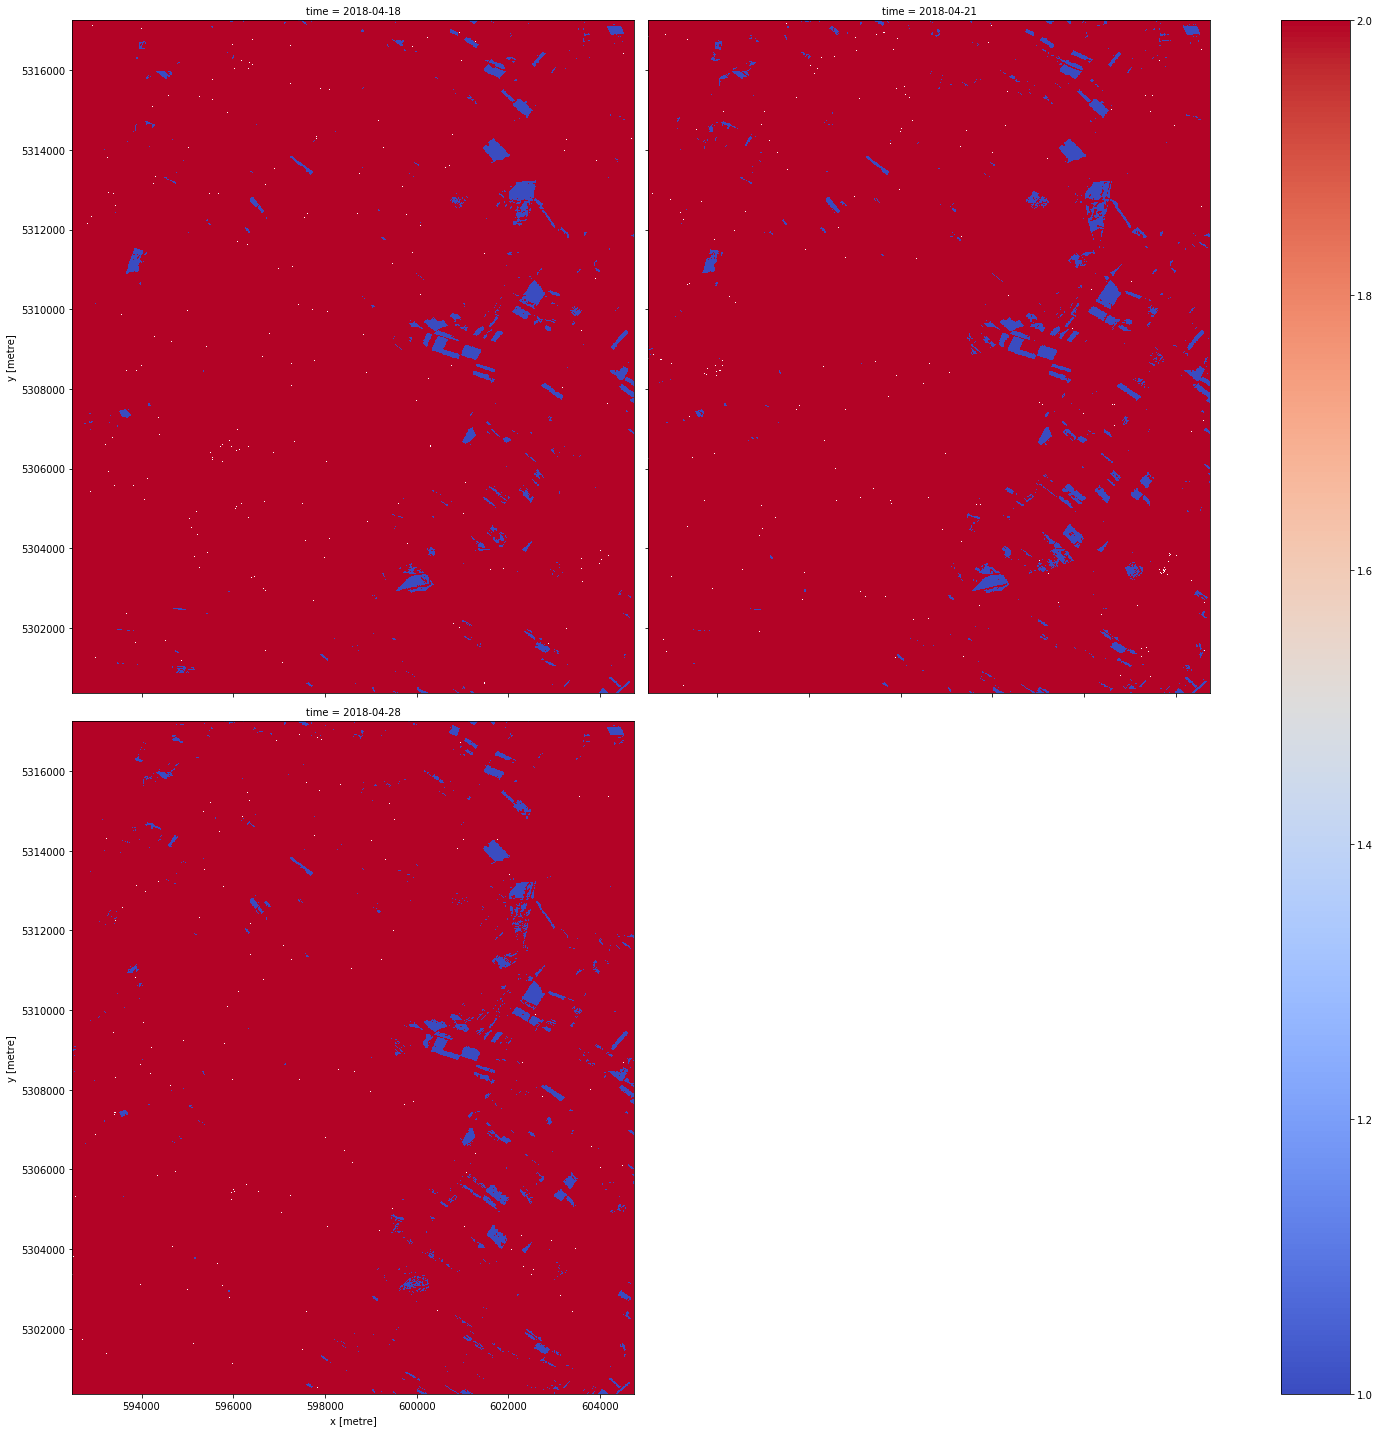

In [9]:
ndwi_mask_waterbody = 1 * ndwi.where(ndwi > 0.5, other=0)/ndwi
ndwi_mask_land = 2 * ndwi.where(ndwi <= 0.5, other=0)/ndwi
ndwi_classified = ndwi_mask_waterbody + ndwi_mask_land
ndwi_classified.plot.imshow(x=data.crs.dimensions[1], 
                 y=data.crs.dimensions[0],
                 col='time',
                 size=10,
                 col_wrap=2,
                 cmap='coolwarm')